<a href="https://colab.research.google.com/github/rhea-modey/MaskFormer/blob/main/MaskFormer/Fine-tuning/Fine_tuning_MaskFormer_on_a_panoptic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: fine-tune MaskFormer for panoptic segmentation

In this notebook, we'll fine-tune MaskFormer on a toy panoptic segmentation dataset. As can be seen, MaskFormer treats any image segmentation task (instance, semantic, panoptic) using the same "mask classification" paradigm.

Panoptic segmentation is about predicting a set of "segments" related to an image. Segments can be either instances or general semantic categories like "sky" or "grass"). It can be viewed as a unification of instance and semantic segmentation.

## Set-up environment

First let's install the required libraries. We install 🤗 Transformers and 🤗 Datasets and also use [Albumentations](https://albumentations.ai/) for some data augmentation. The latter is of course just a choice, you can also use Torchvision, Kornia or imgaug for instance.

In [7]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
!pip install -q albumentations

## Load dataset

I prepared a small panoptic demo dataset based on ADE20k. Let's load it from the [hub](https://huggingface.co/datasets/nielsr/ade20k-panoptic-demo):

In [9]:
from datasets import load_dataset

dataset = load_dataset("nielsr/ade20k-panoptic-demo")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/685 [00:00<?, ?B/s]

(…)-00000-of-00001-01b47ae5ec68b0f0.parquet:   0%|          | 0.00/495k [00:00<?, ?B/s]

(…)-00000-of-00001-80ca2dc8eddf2618.parquet:   0%|          | 0.00/455k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10 [00:00<?, ? examples/s]

Let's look at it in more detail. It's tiny as you can see:

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'segments_info'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['image', 'label', 'segments_info'],
        num_rows: 10
    })
})

Let's look at the first training example. Each example consists of an image, a label (which is the ground truth panoptic segmentation map) and a corresponding segments_info, which contains more information about the segments in the map.

In [12]:
example = dataset["train"][0]
example.keys()

dict_keys(['image', 'label', 'segments_info'])

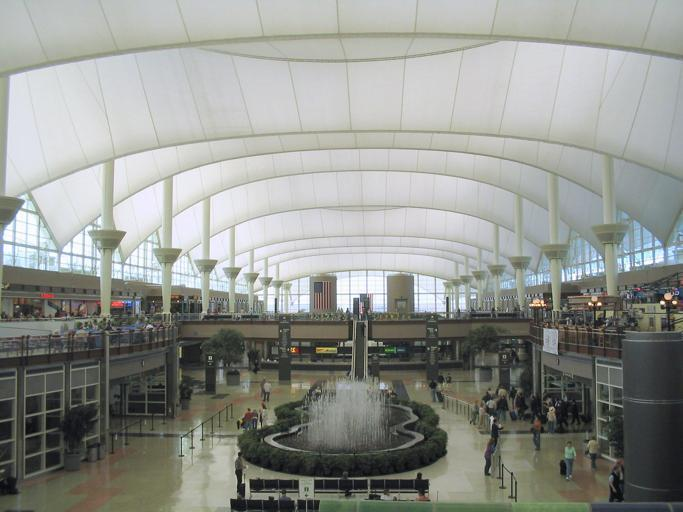

In [13]:
image = example["image"]
image

The corresponding segmentation map looks like this:

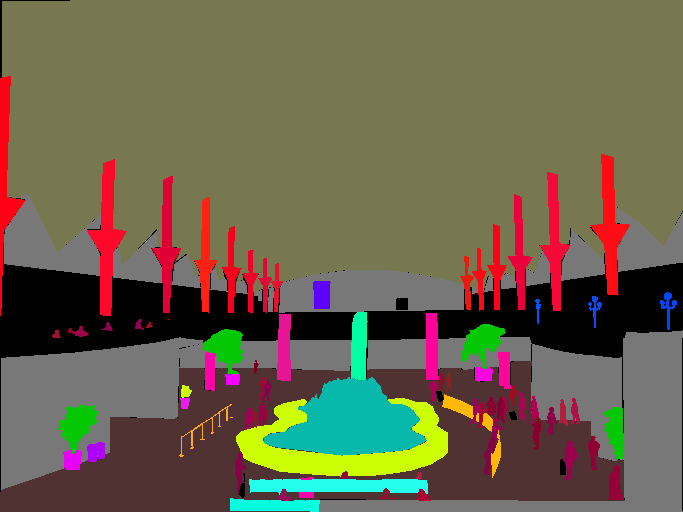

In [14]:
example['label']

The ground truth segmentation maps are stored as PNG images with 3 channels (red, green blue). However if we want to know the actual segment IDs in this segmentation map (one segment ID per pixel), we need to convert the RGB image using the rgb_to_id function.

In [15]:
import numpy as np
from transformers.image_transforms import rgb_to_id

# convert RGB to segment IDs per pixel
# 0 is the "ignore" label, for which we don't need to make binary masks
panoptic_map = rgb_to_id(np.array(example['label']))
panoptic_map

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

array([[      0,       0,       0, ..., 5273720, 5273720, 5273720],
       [      0,       0, 5273720, ..., 5273720, 5273720, 5273720],
       [      0,       0, 5273720, ..., 5273720, 5273720, 5273720],
       ...,
       [3289680, 3289680, 3289680, ..., 7895160, 7895160,       0],
       [3289680, 3289680, 3289680, ..., 7895160, 7895160,       0],
       [3289680, 3289680, 3289680, ..., 7895160, 7895160, 7895160]],
      dtype=int32)

Now we have a map that labels each pixel with a certain "segment ID". Let's look at the unique segment IDs in this map:

In [ ]:
np.unique(panoptic_map)

array([       0,   247812,   327628,   440575,  1121003,  1310975,
        1450495,  1510655,  1638655,  1640959,  1900791,  1943551,
        2034595,  2040455,  2293881,  2556040,  2621579,  2621682,
        2689279,  2888324,  2952868,  3014829,  3019496,  3080327,
        3084183,  3150492,  3211398,  3211431,  3289680,  3412627,
        3473552,  3473576,  3539093,  3539169,  3540961,  3541494,
        3736474,  3932395,  3999126,  4136881,  4194469,  4261758,
        4268972,  4460466,  4587660,  4653192,  4654489,  4718745,
        5046408,  5111955,  5111963,  5179045,  5273720,  5439638,
        5505199,  5570705,  5636255,  5636267,  5836185,  5898396,
        7895160,  9704934, 10027775, 10028543, 10747648, 11075835,
       11188232, 11272447, 14745351, 14745855, 15466276, 15604973,
       15665071, 15813135, 16646379, 16711772, 16711853, 16711925,
       16729856, 16734209], dtype=int32)

It looks like there are a lot of segments in this image. This is also confirmed when we look at the corresponding segments_info of this example, which contains more information about those segments:

In [ ]:
# print first 10 segments
for segment in example['segments_info'][:10]:
  print(segment)

{'area': 61273, 'bbox': [1, 194, 682, 318], 'category_id': 0, 'id': 7895160, 'iscrowd': 0}
{'area': 40786, 'bbox': [0, 361, 625, 151], 'category_id': 3, 'id': 3289680, 'iscrowd': 0}
{'area': 3887, 'bbox': [58, 324, 566, 136], 'category_id': 4, 'id': 247812, 'iscrowd': 0}
{'area': 166409, 'bbox': [2, 0, 681, 292], 'category_id': 5, 'id': 5273720, 'iscrowd': 0}
{'area': 6803, 'bbox': [181, 385, 267, 92], 'category_id': 17, 'id': 327628, 'iscrowd': 0}
{'area': 995, 'bbox': [351, 312, 17, 68], 'category_id': 96, 'id': 10747648, 'iscrowd': 0}
{'area': 46, 'bbox': [341, 472, 8, 7], 'category_id': 12, 'id': 3999126, 'iscrowd': 0}
{'area': 78, 'bbox': [380, 488, 17, 11], 'category_id': 12, 'id': 3084183, 'iscrowd': 0}
{'area': 107, 'bbox': [416, 489, 15, 12], 'category_id': 12, 'id': 3014829, 'iscrowd': 0}
{'area': 87, 'bbox': [278, 489, 14, 12], 'category_id': 12, 'id': 5836185, 'iscrowd': 0}


This indicates for instance that all pixels labeled with segment ID == 7895160 have the category ID == 0. The category IDs are the actual classes of this particular dataset. As this dataset is a small subset of ADE20k, these category IDs are the ADE20k classes (there are 150 of them).


Let's create a mapping between segment IDs and category IDs:

In [ ]:
inst2class = {segment['id']: segment['category_id'] for segment in example['segments_info']}
print(inst2class)

{7895160: 0, 3289680: 3, 247812: 4, 5273720: 5, 327628: 17, 10747648: 96, 3999126: 12, 3084183: 12, 3014829: 12, 5836185: 12, 4261758: 12, 5111963: 12, 3473552: 12, 2556040: 12, 2040455: 12, 2888324: 12, 5636267: 12, 3080327: 12, 3211398: 12, 4194469: 12, 4587660: 12, 4460466: 12, 5179045: 12, 3539093: 12, 2034595: 12, 4136881: 12, 5505199: 12, 4653192: 12, 3736474: 12, 4718745: 12, 3412627: 12, 5636255: 12, 4268972: 12, 3473576: 12, 5046408: 12, 2293881: 12, 5898396: 12, 3211431: 12, 5111955: 12, 5439638: 12, 2952868: 12, 5570705: 12, 4654489: 12, 3150492: 12, 2621579: 12, 14745351: 31, 15466276: 31, 440575: 32, 1943551: 32, 2689279: 42, 3539169: 42, 1450495: 42, 1900791: 42, 2621682: 42, 3540961: 42, 3019496: 42, 1121003: 42, 1310975: 42, 1510655: 42, 3541494: 42, 3932395: 42, 1638655: 42, 1640959: 42, 10028543: 43, 11272447: 43, 11075835: 43, 10027775: 43, 9704934: 43, 16729856: 87, 15813135: 87, 16734209: 87, 11188232: 104, 16711925: 125, 14745855: 125, 16646379: 125, 15604973: 125

Let's load the ADE20k classes:

In [ ]:
from huggingface_hub import hf_hub_download
import json

# the categories are the regular 150 classes of ADE20k
repo_id = f"huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

Downloading:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

{0: 'wall', 1: 'building', 2: 'sky', 3: 'floor', 4: 'tree', 5: 'ceiling', 6: 'road', 7: 'bed ', 8: 'windowpane', 9: 'grass', 10: 'cabinet', 11: 'sidewalk', 12: 'person', 13: 'earth', 14: 'door', 15: 'table', 16: 'mountain', 17: 'plant', 18: 'curtain', 19: 'chair', 20: 'car', 21: 'water', 22: 'painting', 23: 'sofa', 24: 'shelf', 25: 'house', 26: 'sea', 27: 'mirror', 28: 'rug', 29: 'field', 30: 'armchair', 31: 'seat', 32: 'fence', 33: 'desk', 34: 'rock', 35: 'wardrobe', 36: 'lamp', 37: 'bathtub', 38: 'railing', 39: 'cushion', 40: 'base', 41: 'box', 42: 'column', 43: 'signboard', 44: 'chest of drawers', 45: 'counter', 46: 'sand', 47: 'sink', 48: 'skyscraper', 49: 'fireplace', 50: 'refrigerator', 51: 'grandstand', 52: 'path', 53: 'stairs', 54: 'runway', 55: 'case', 56: 'pool table', 57: 'pillow', 58: 'screen door', 59: 'stairway', 60: 'river', 61: 'bridge', 62: 'bookcase', 63: 'blind', 64: 'coffee table', 65: 'toilet', 66: 'flower', 67: 'book', 68: 'hill', 69: 'bench', 70: 'countertop', 71

In [ ]:
assert len(id2label) == 150

We now know for instance that all pixels labeled with segment ID == 0 actually are of category "wall".

Let's visualize the binary mask of this segment:

Visualizing a segment of semantic category: wall


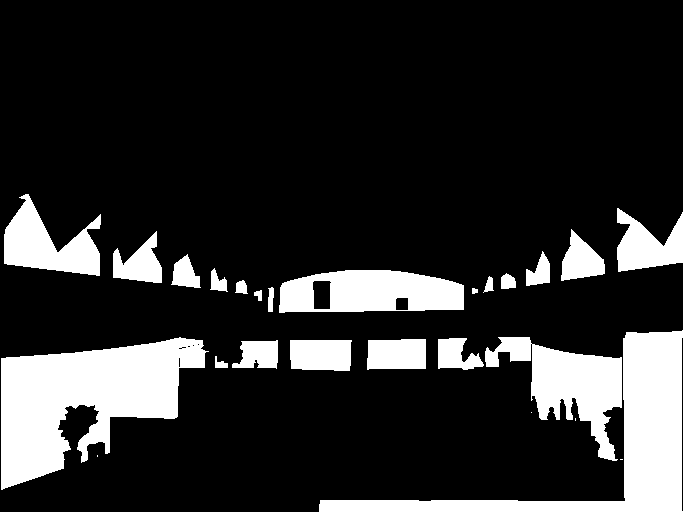

In [ ]:
from PIL import Image

print("Visualizing a segment of semantic category:", id2label[inst2class[7895160]])

mask = (panoptic_map == 7895160)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Let's visualize another segment:

Visualizing a segment of semantic category: plant


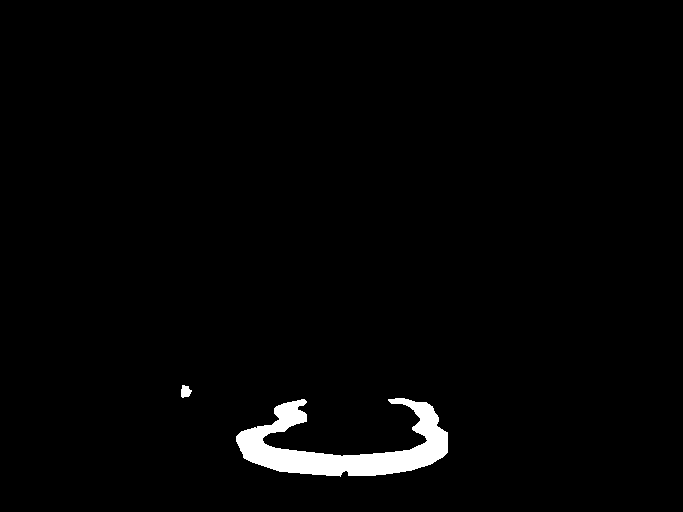

In [ ]:
from PIL import Image

print("Visualizing a segment of semantic category:", id2label[inst2class[327628]])

mask = (panoptic_map == 327628)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

## Prepare single example for model

Let's prepare this single example (image, with corresponding ground truth panoptic map and segments info) for the model.

Essentially we need to create a set of binary masks and corresponding labels (for all segments) for the image, as that's how MaskFormer is trained. We can leverage the image processor for that.

In [ ]:
from transformers import MaskFormerImageProcessor

# we don't want to reduce labels here
# we set resizing, rescaling and normalizing here to False as we'll use Albumentations for that (see further)
processor = MaskFormerImageProcessor(ignore_index=0, do_resize=False, do_rescale=False, do_normalize=False)

In [ ]:
# prepare image + label for the model
inputs = processor(image, panoptic_map, instance_id_to_semantic_id=inst2class, return_tensors="pt")

In [ ]:
import torch

for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([1, 3, 512, 683])
pixel_mask torch.Size([1, 512, 683])
mask_labels 1
class_labels 1


This was just to show what the model inputs are: pixel_values, which is the image prepared for the model, a corresponding pixel mask (which indicates which pixels are real = 1 and which are padding = 0), and then the binary masks and corresponding class labels.

Note that we haven't resized + normalized the image here, but we'll do that below when actually preparing all examples for the model.

## Create PyTorch Dataset

Now that we've shown how to prepare a single example, we can define a regular PyTorch dataset that does this for each item of the dataset.

In [ ]:
import numpy as np
from torch.utils.data import Dataset
import torch

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"])
        panoptic_seg_gt = np.array(self.dataset[idx]['label'])

        # apply transforms (need to be applied on RGB values)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=panoptic_seg_gt)
            image, panoptic_seg_gt = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        panoptic_seg_gt = rgb_to_id(panoptic_seg_gt)
        inst2class = {segment['id']: segment['category_id'] for segment in self.dataset[idx]['segments_info']}

        inputs = self.processor([image], [panoptic_seg_gt], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

We'll use some image transformations from Albumentations. Of course you can include more fancy data augmentation here (like random cropping, flipping, color jitter etc.) to make the model more robust.

In [ ]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

image_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# create PyTorch datasets
train_dataset = ImageSegmentationDataset(dataset["train"], processor, transform=image_transform)
test_dataset = ImageSegmentationDataset(dataset["validation"], processor, transform=image_transform)

## Verify data creation

As always, it's very important to check whether the data is prepared in the correct way. Let's look at the first example:

In [ ]:
inputs = train_dataset[0]

In [ ]:
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([79, 512, 512])
class_labels torch.Size([79])


We can "denormalize" the pixel values and see whether we get a proper image back.

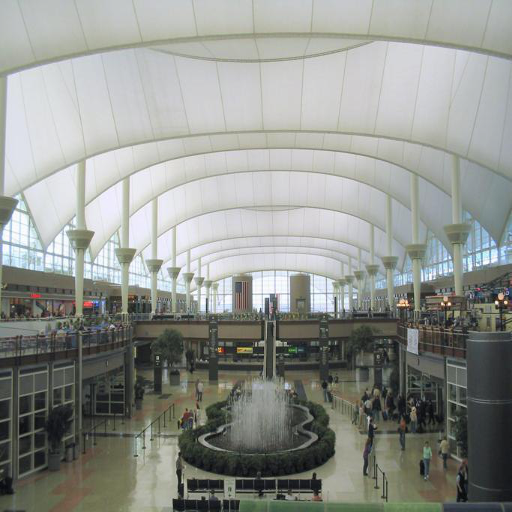

In [ ]:
from PIL import Image

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (inputs["pixel_values"].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Cool! Let's also verify the binary masks and class labels being created.

In [ ]:
inputs["class_labels"]

tensor([  4,  17,  32,  42,  42,  42,  42,  42,  42,  42,  32,  12,  12,  12,
         12,  12,  42,  42,  12,  12,  12,  42,  12,  12,  12,  12,  12,   3,
         12,  12,  12,  12,  42,  42,  42,  12,  42,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,   5,  12,  12,  12,  12,
         12,  12,  12,   0,  43,  43,  43,  96,  43, 104,  43,  31, 125,  31,
        125, 138,  87, 125, 149, 138, 125,  87,  87])

Visualizing mask for: tree


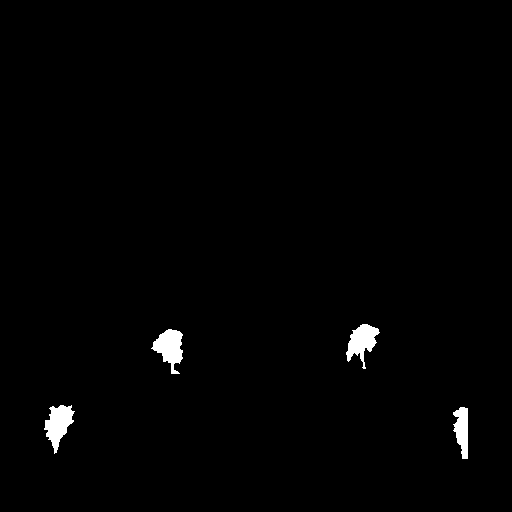

In [ ]:
print("Visualizing mask for:", id2label[inputs["class_labels"][0].item()])

visual_mask = (inputs["mask_labels"][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Visualizing mask for: plant


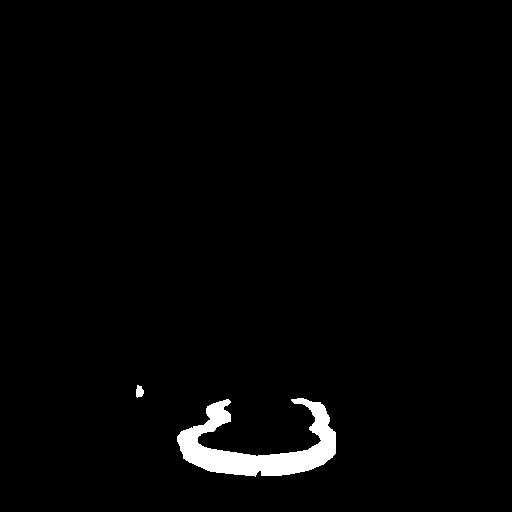

In [ ]:
print("Visualizing mask for:", id2label[inputs["class_labels"][1].item()])

visual_mask = (inputs["mask_labels"][1].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Visualizing mask for: fence


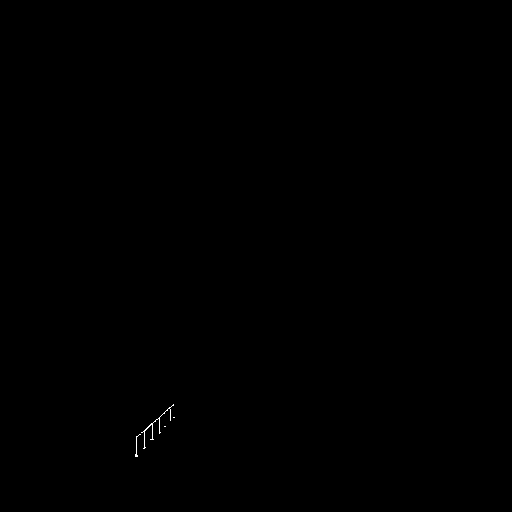

In [ ]:
print("Visualizing mask for:", id2label[inputs["class_labels"][10].item()])

visual_mask = (inputs["mask_labels"][10].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

## Create PyTorch DataLoader

Next, we can create a corresponding PyTorch DataLoader, which allows to get batches of examples from the dataset.

This is required as neural networks are trained on batches of examples, using stochastic gradient descent (SGD).

In [ ]:
from torch.utils.data import DataLoader

# define custom collate function which defines how to batch examples together
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

## Verify data (!!)

Again let's make sure our data is prepared correctly for MaskFormer. Let's take the first batch and do some sanity checks.

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k, len(v))

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2


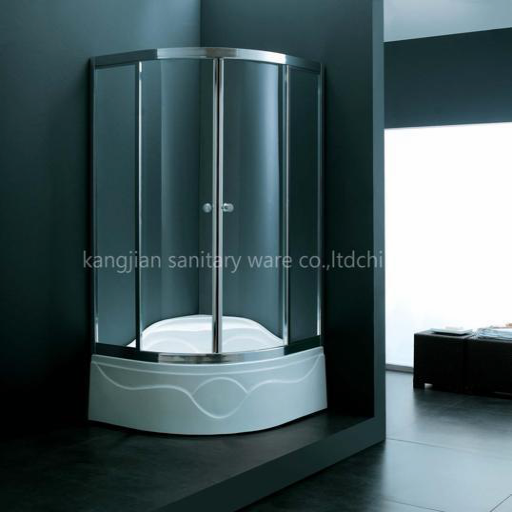

In [ ]:
from PIL import Image

batch_index = 1

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Visualizing mask for: floor


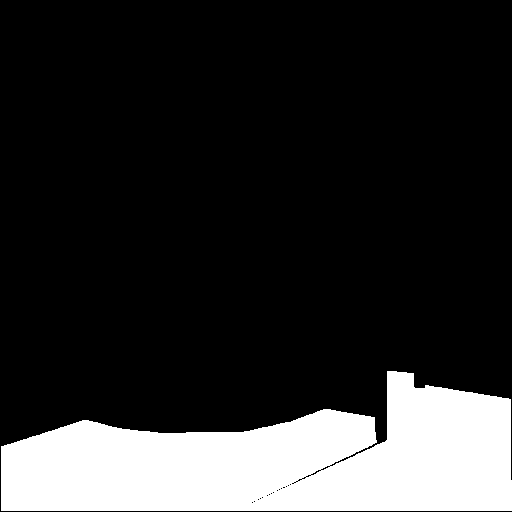

In [ ]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Visualizing mask for: ceiling


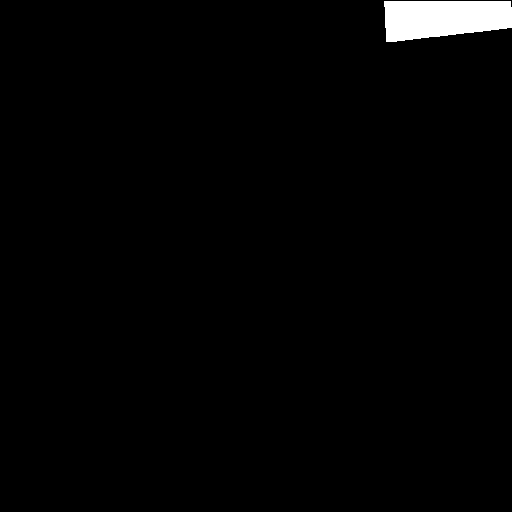

In [ ]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][1].item()])

visual_mask = (batch["mask_labels"][batch_index][1].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

This looks ok!

## Define the model

Next we define the model, equip it with pre-trained weights (here we load a MaskFormer model already fine-tuned on COCO panoptic), and replace the existing classification head by a new one.

In [ ]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-coco and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([151, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([151]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([151]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Compute initial loss

It's always good to check whether the initial loss makes sense, see [this excellent blog post](http://karpathy.github.io/2019/04/25/recipe/) for several nice ways to debug neural networks.

In [ ]:
# verify forward pass
outputs = model(
          pixel_values=batch["pixel_values"],
          mask_labels=batch["mask_labels"],
          class_labels=batch["class_labels"],
      )
outputs.loss

tensor([5.9910], grad_fn=<AddBackward0>)

## Train the model

We'll train the model in regular PyTorch fashion.

Of course, feel free to update to use the HuggingFace [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer), [PyTorch Lightning](https://www.pytorchlightning.ai/) or HuggingFace [Accelerate](https://huggingface.co/docs/accelerate/index).

In [ ]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(100):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.443909168243408
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.911618153254191
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.731655099175193
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.502233900129795
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3843319302513484
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.229013360463656
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.127590767798885
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0440368784798517
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9837220732758685
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9129832283310269
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8513536196128995
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.80316647035735
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.760788683031426
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7012773580623395
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6618597944017868
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6073184656469446
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5693204241034426
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5343639226846917
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4969355667030417
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4620504397898912
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.431986415150142
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4017545769237123
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3700287994500753
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3399626831042355
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.312922995445157
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2854430273411765
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2623882125352175
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2345332939396887
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2139509335054572
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1903960945671552
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1716931525445142
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1471648642267935
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1270658875474278
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1079729974987995
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.091855333911048
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.072684071450071
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0577222984798706
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.039777577083598
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0225782125252079
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0093868660683534
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9923370575801057
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9805015016311002
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9652504662837462
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9524857287674591
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9378110393881798
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9252674315553323
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9154826402986721
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9037999197272426
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8902584306617496
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8790380828446005
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8681345129036808
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8583573834039271
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8477596914345734
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8376718323985884
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.826376485731109
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8168477118825135
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8079366062724718
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7996975861072957
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7903439716221541
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7811104453395348
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7719145362757369
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7644905266808528
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7565188429219546
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7477920276313266
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7395936217031375
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7326166017518088
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7274163890506206
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7202506804439638
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7137053536573463
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7077358823506473
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7018717533969812
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6965068894114053
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6918417506972508
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6859935104765528
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6805645408374923
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6814794242183896
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6755368367541493
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6704103921593162
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6648072618848223
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6608322957963354
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6567731097043303
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6516154846864675
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6467690870999709
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6409631543345033
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6369893091007395
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6322735380031553
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6273940150342934
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6227879798586625
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6181624304765071
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6141278795446916
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6103267703048406
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6055367788659376
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6022509616716823
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5979951983837355
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5931584542723978
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5889562551213914
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5853356383818351
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5820259601261022
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5774494854850949
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5742217142270097


## Inference

After training, we can use the model to make predictions on new images.

Let's take an example:

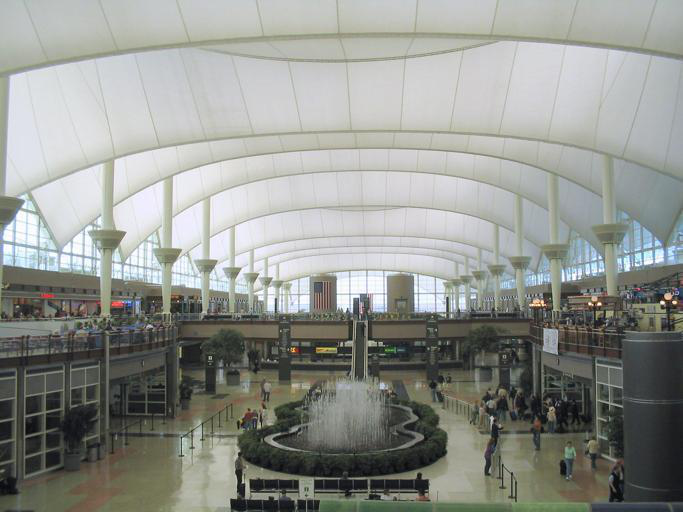

In [ ]:
idx = 0

image = dataset["train"][idx]["image"]
image

In [ ]:
pixel_values = image_transform(image=np.array(image))["image"]
print(pixel_values.shape)

(512, 512, 3)


In [ ]:
import torch

pixel_values = np.moveaxis(pixel_values, -1, 0)
pixel_values = torch.from_numpy(pixel_values).unsqueeze(0)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
# forward pass
with torch.no_grad():
  outputs = model(pixel_values.to(device))

In [ ]:
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


In [ ]:
predicted_panoptic_seg = results['segmentation'].cpu().numpy()
predicted_panoptic_seg

array([[ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [21, 21, 21, ..., 25, 25, 25],
       [21, 21, 21, ..., 25, 25, 25],
       [21, 21, 21, ..., 25, 25, 25]], dtype=int32)

In [ ]:
results['segments_info']

[{'id': 1, 'label_id': 12, 'was_fused': False, 'score': 0.894758},
 {'id': 2, 'label_id': 31, 'was_fused': False, 'score': 0.837781},
 {'id': 3, 'label_id': 12, 'was_fused': False, 'score': 0.982657},
 {'id': 4, 'label_id': 42, 'was_fused': False, 'score': 0.972912},
 {'id': 5, 'label_id': 104, 'was_fused': False, 'score': 0.798848},
 {'id': 6, 'label_id': 5, 'was_fused': False, 'score': 0.983055},
 {'id': 7, 'label_id': 12, 'was_fused': False, 'score': 0.99263},
 {'id': 8, 'label_id': 17, 'was_fused': False, 'score': 0.863936},
 {'id': 9, 'label_id': 42, 'was_fused': False, 'score': 0.956084},
 {'id': 10, 'label_id': 12, 'was_fused': False, 'score': 0.976295},
 {'id': 11, 'label_id': 42, 'was_fused': False, 'score': 0.935656},
 {'id': 12, 'label_id': 12, 'was_fused': False, 'score': 0.992342},
 {'id': 13, 'label_id': 42, 'was_fused': False, 'score': 0.963704},
 {'id': 14, 'label_id': 12, 'was_fused': False, 'score': 0.989954},
 {'id': 15, 'label_id': 42, 'was_fused': False, 'score': 0

Visualizing mask for: person


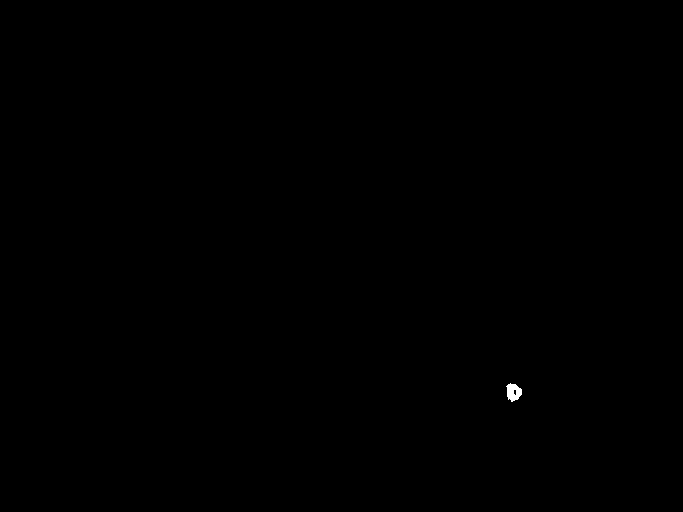

In [ ]:
from PIL import Image

def get_mask(segment_idx):
    segment = results['segments_info'][segment_idx]

    print("Visualizing mask for:", id2label[segment['label_id']])

    mask = (predicted_panoptic_seg == segment['id'])

    visual_mask = (mask * 255).astype(np.uint8)
    return Image.fromarray(visual_mask)

get_mask(0)

Visualizing mask for: seat


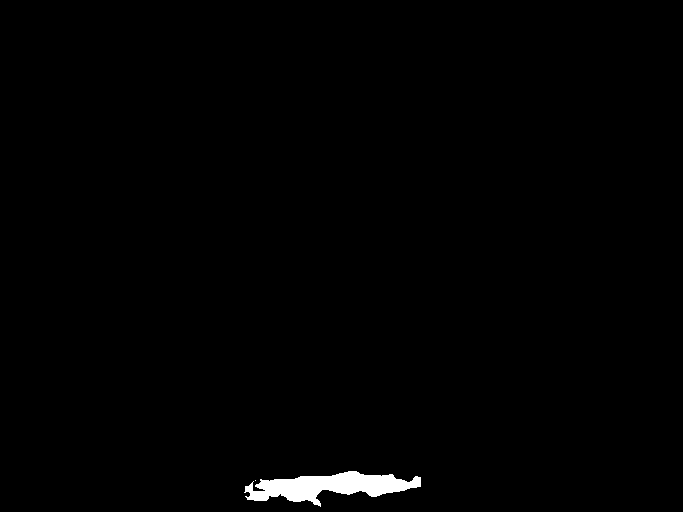

In [ ]:
get_mask(1)

Visualizing mask for: ceiling


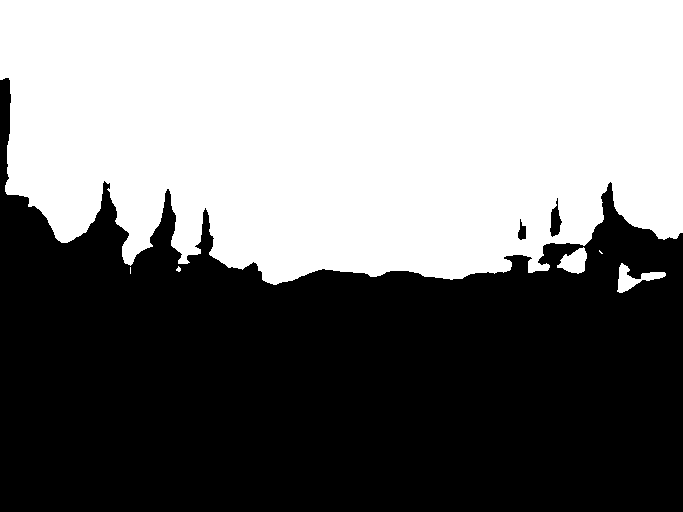

In [ ]:
get_mask(5)

Visualizing mask for: column


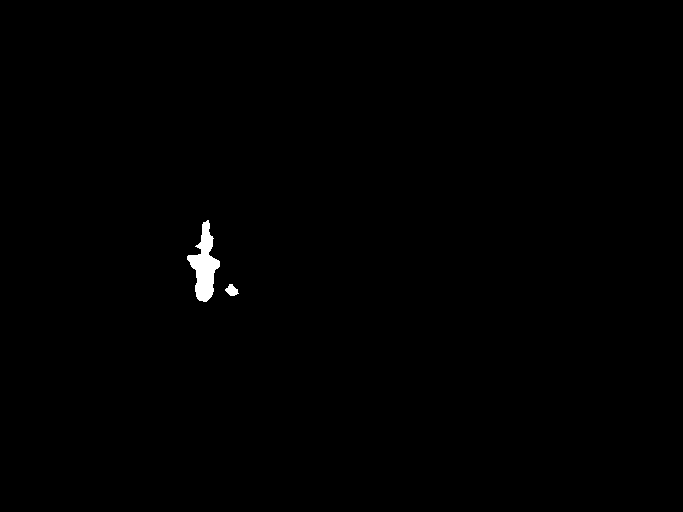

In [ ]:
get_mask(8)

To make a nice visualization of all segments in one go, refer to my [inference notebooks of MaskFormer](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/MaskFormer).